In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools


from iarchitect import envs,trainer as trainer_iarch
from iarchitect.agents import dqn as dqn_iarch
from iarchitect.common import show_policy_behaviour,create_policy_eval_video
from iarchitect.common.callbacks import output_updater,update_plotter,fig_trainer

from tf_agents.agents import DdpgAgent,DqnAgent

from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers

In [73]:
SOLUTION_NAME = "WindowEnvWhatPlantrandomResetWith5FruitsOnly"

In [143]:
environment = envs.WindowEnv(16,
                             np.fromiter(range(10),dtype=int),random_reset=False,
                            render_dims=(4,4),max_species_reset=5)
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

In [144]:
environment.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([1. , 0. , 1. , 0.5, 1. , 1. , 0. , 1. , 0. , 1. , 0. ],
      dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

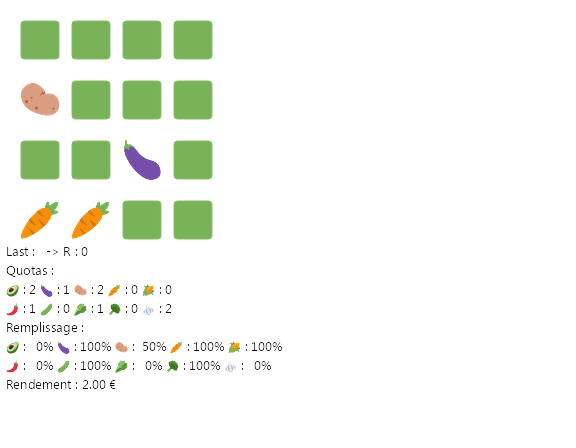

In [146]:
environment.render_image()

In [147]:
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu",
        kernel_initializer=initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
def network(fc_layers_units,dimension_q_values):
    q_values_layer = layers.Dense(
            dimension_q_values,
            activation=None,
            kernel_initializer=initializers.RandomUniform(
                minval=-0.03, maxval=0.03),
            bias_initializer=initializers.Constant(-0.2))
    return sequential.Sequential([layers.Flatten()] + [dense_layer(n) for n in fc_layers_units] + [q_values_layer])


In [162]:
agent = DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=network((20,20),len(environment.tuiles)),
        optimizer=Adam(learning_rate=0.0005),
        td_errors_loss_fn=common.element_wise_squared_loss,
        epsilon_greedy=0.9)
agent.initialize()

In [163]:
def plot_obs(obs,ax):
    return ax.imshow(obs,vmin=0.0,vmax=1.0,cmap="coolwarm")

def plot_env(env,ax):
    return ax.imshow(env.envs[0].render("rgb_array"))


def evaluate_policy(each_step=1,n_epochs=5):
    def evaluate_(step,trainer):
        if step % each_step == 0:
            for _ in range(n_epochs):
                time_step = trainer.tf_env.reset()
                while not time_step.is_last():
                    print(trainer.tf_env.envs[0].render())
                    action_step = trainer.agent.policy.action(time_step)
                    time_step = trainer.tf_env.step(action_step.action)
                display(trainer.tf_env.envs[0].render())
                display("----------- end --------------")
    return evaluate_


In [164]:
trainer = trainer_iarch.Trainer(train_env,agent)
trainer.initialize_buffer(min_size=640,random_policy=True)

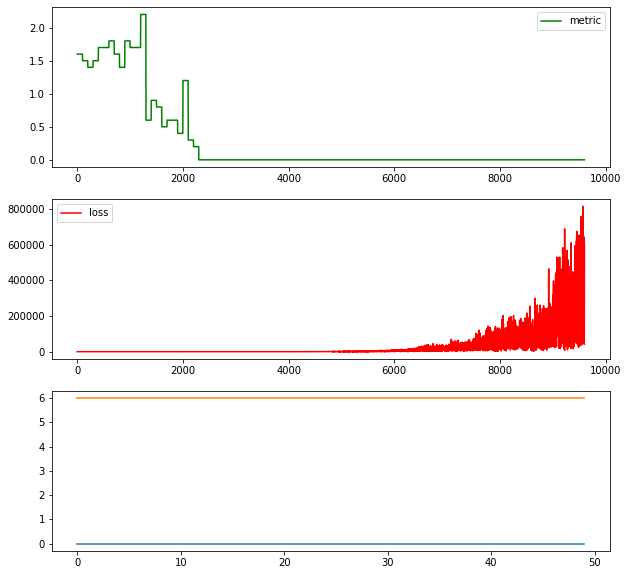

🟩 🟩 🟩 🟩
🟩 🟩 🥬 🌽
🟩 🥬 🟩 🟩
🟩 🟩 🥕 🍆
Last :   -> R : 0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :   0%
Rendement : 2.00 € 
🥒 🟩 🟩 🟩
🟩 🟩 🥬 🌽
🟩 🥬 🟩 🟩
🟩 🟩 🥕 🍆
Last : 🥒 @ [0],[0] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :   0%
Rendement : 2.00 € 
🥒 🥒 🟩 🟩
🟩 🟩 🥬 🌽
🟩 🥬 🟩 🟩
🟩 🟩 🥕 🍆
Last : 🥒 @ [0],[1] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :   0%
Rendement : 2.00 € 
🥒 🥒 🥒 🟩
🟩 🟩 🥬 🌽
🟩 🥬 🟩 🟩
🟩 🟩 🥕 🍆
Last : 🥒 @ [0],[2] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :  

'🥒 🥒 🥒 🥒\n🥒 🥒 🥬 🌽\n🥒 🥬 🥒 🥒\n🥒 🥒 🥕 🍆\nLast : 🥒 @ [3],[1] -> R : 0.0\nQuotas : \n🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0\n🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2\nRemplissage : \n🥑 :   0% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%\n🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :   0%\nRendement : 2.00 € '

'----------- end --------------'

🟩 🟩 🟩 🥑
🟩 🟩 🟩 🥒
🟩 🟩 🟩 🥒
🟩 🟩 🥑 🟩
Last :   -> R : 0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 : 100% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :   0%
Rendement : 2.00 € 
🥒 🟩 🟩 🥑
🟩 🟩 🟩 🥒
🟩 🟩 🟩 🥒
🟩 🟩 🥑 🟩
Last : 🥒 @ [0],[0] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 : 100% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :   0%
Rendement : 2.00 € 
🥒 🥒 🟩 🥑
🟩 🟩 🟩 🥒
🟩 🟩 🟩 🥒
🟩 🟩 🥑 🟩
Last : 🥒 @ [0],[1] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 : 100% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :   0%
Rendement : 2.00 € 
🥒 🥒 🥒 🥑
🟩 🟩 🟩 🥒
🟩 🟩 🟩 🥒
🟩 🟩 🥑 🟩
Last : 🥒 @ [0],[2] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 : 100% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :  

'🥒 🥒 🥒 🥑\n🥒 🥒 🥒 🥒\n🥒 🥒 🥒 🥒\n🥒 🥒 🥑 🥒\nLast : 🥒 @ [3],[3] -> R : 0.0\nQuotas : \n🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0\n🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2\nRemplissage : \n🥑 : 100% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%\n🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :   0%\nRendement : 2.00 € '

'----------- end --------------'

🟩 🥬 🟩 🟩
🟩 🟩 🟩 🧄
🌶️ 🟩 🥬 🟩
🟩 🥦 🟩 🟩
Last :   -> R : 0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ : 100% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :  50%
Rendement : 3.00 € 
🥒 🥬 🟩 🟩
🟩 🟩 🟩 🧄
🌶️ 🟩 🥬 🟩
🟩 🥦 🟩 🟩
Last : 🥒 @ [0],[0] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ : 100% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :  50%
Rendement : 3.00 € 
🥒 🥬 🥒 🟩
🟩 🟩 🟩 🧄
🌶️ 🟩 🥬 🟩
🟩 🥦 🟩 🟩
Last : 🥒 @ [0],[2] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ : 100% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :  50%
Rendement : 3.00 € 
🥒 🥬 🥒 🥒
🟩 🟩 🟩 🧄
🌶️ 🟩 🥬 🟩
🟩 🥦 🟩 🟩
Last : 🥒 @ [0],[3] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ : 100% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄

'🥒 🥬 🥒 🥒\n🥒 🥒 🥒 🧄\n🌶️ 🥒 🥬 🥒\n🥒 🥦 🥒 🥒\nLast : 🥒 @ [3],[3] -> R : 0.0\nQuotas : \n🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0\n🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2\nRemplissage : \n🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%\n🌶️ : 100% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :  50%\nRendement : 3.00 € '

'----------- end --------------'

🟩 🟩 🟩 🧄
🟩 🟩 🟩 🟩
🟩 🟩 🟩 🥦
🍆 🟩 🟩 🥑
Last :   -> R : 0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :  50% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :  50%
Rendement : 3.00 € 
🥒 🟩 🟩 🧄
🟩 🟩 🟩 🟩
🟩 🟩 🟩 🥦
🍆 🟩 🟩 🥑
Last : 🥒 @ [0],[0] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :  50% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :  50%
Rendement : 3.00 € 
🥒 🥒 🟩 🧄
🟩 🟩 🟩 🟩
🟩 🟩 🟩 🥦
🍆 🟩 🟩 🥑
Last : 🥒 @ [0],[1] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :  50% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :  50%
Rendement : 3.00 € 
🥒 🥒 🥒 🧄
🟩 🟩 🟩 🟩
🟩 🟩 🟩 🥦
🍆 🟩 🟩 🥑
Last : 🥒 @ [0],[2] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :  50% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :  

'🥒 🥒 🥒 🧄\n🥒 🥒 🥒 🥒\n🥒 🥒 🥒 🥦\n🍆 🥒 🥒 🥑\nLast : 🥒 @ [3],[2] -> R : 0.0\nQuotas : \n🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0\n🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2\nRemplissage : \n🥑 :  50% 🍆 : 100% 🥔 :   0% 🥕 : 100% 🌽 : 100%\n🌶️ :   0% 🥒 : 100% 🥬 :   0% 🥦 : 100% 🧄 :  50%\nRendement : 3.00 € '

'----------- end --------------'

🟩 🟩 🟩 🥬
🟩 🟩 🟩 🟩
🟩 🥦 🟩 🥒
🟩 🥬 🟩 🟩
Last :   -> R : 0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :   0%
Rendement : 1.00 € 
🥒 🟩 🟩 🥬
🟩 🟩 🟩 🟩
🟩 🥦 🟩 🥒
🟩 🥬 🟩 🟩
Last : 🥒 @ [0],[0] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :   0%
Rendement : 1.00 € 
🥒 🥒 🟩 🥬
🟩 🟩 🟩 🟩
🟩 🥦 🟩 🥒
🟩 🥬 🟩 🟩
Last : 🥒 @ [0],[1] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :   0%
Rendement : 1.00 € 
🥒 🥒 🥒 🥬
🟩 🟩 🟩 🟩
🟩 🥦 🟩 🥒
🟩 🥬 🟩 🟩
Last : 🥒 @ [0],[2] -> R : 0.0
Quotas : 
🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0
🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2
Remplissage : 
🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%
🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :  

'🥒 🥒 🥒 🥬\n🥒 🥒 🥒 🥒\n🥒 🥦 🥒 🥒\n🥒 🥬 🥒 🥒\nLast : 🥒 @ [3],[3] -> R : 0.0\nQuotas : \n🥑 : 2 🍆 : 1 🥔 : 2 🥕 : 0 🌽 : 0\n🌶️ : 1 🥒 : 0 🥬 : 1 🥦 : 0 🧄 : 2\nRemplissage : \n🥑 :   0% 🍆 :   0% 🥔 :   0% 🥕 : 100% 🌽 : 100%\n🌶️ :   0% 🥒 : 100% 🥬 : 100% 🥦 : 100% 🧄 :   0%\nRendement : 1.00 € '

'----------- end --------------'

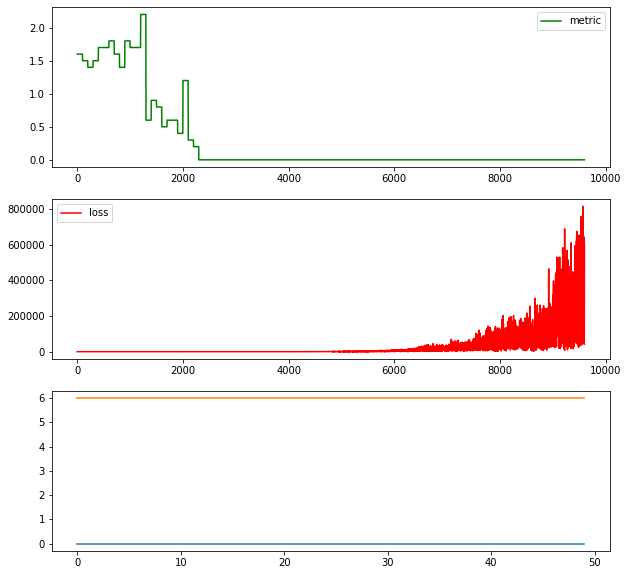

In [165]:
fig_tr = fig_trainer(3,1,figsize=(10,10))
callbacks = [update_plotter(fig_tr),
             output_updater(fig_tr,clear_output=True),
             evaluate_policy(n_epochs=5)
             ]

trainer.run(callbacks=callbacks,
            buffer_size_increase_per_iteration = 10,
            sample_batch_size_experience = 64,
            num_iterations_train = 100,
            num_steps_per_row_in_experience = 2
           );

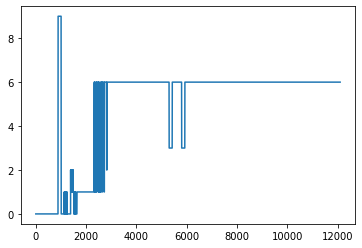

In [166]:
plt.plot([int(t.action) for t in trainer.observer.trajectories()])

(array([3.6795e+04, 0.0000e+00, 0.0000e+00, 1.1600e+03, 0.0000e+00,
        0.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

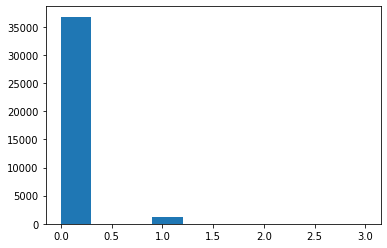

In [142]:
plt.hist(np.squeeze(np.array([t.reward for t in trainer.observer.trajectories()])))

In [157]:
fig_tr.savefig(SOLUTION_NAME+".png")

In [ ]:
environment.reset()
print(environment.step(5).reward)
print(environment.step(2).reward)
print(environment.step(9).reward)
print(environment.step(7).reward)

environment.render_image()

1.0
1.0
1.0
0.0


In [ ]:
create_policy_eval_video(train_env,environment,trainer.agent.policy,SOLUTION_NAME,num_episodes=10,fps=5)

In [ ]:
create_policy_eval_video(train_env,environment,random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),train_env.action_spec()),SOLUTION_NAME + "_random",num_episodes=10,fps=5)

ERROR! Session/line number was not unique in database. History logging moved to new session 375
